# JQOVResNet-16: Document Image classification with ResNet

## Import

In [1]:
import os

import numpy as np

from datasets import load_dataset

import torch
import lightning as L
import torch.nn as nn

import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps

d:\GitHub\deep-learning-projet\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

if not os.path.exists('./results/'):
    os.makedirs('./results/')

## Variables and (hyper-)parameters

In [3]:
IS_DEBUG = True

BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS=100
EARLY_STOP=3

GPUS = [0]

## Function

In [4]:
def my_accuracy(y, y_true):
  return (torch.sum(torch.argmax(y, dim=1) == y_true)/y.shape[0])


def preprocess_image(img):
  img = ImageOps.pad(img, (500, 500), color='white')
  img = np.array(img)
  return img / 255


def dataset_to_tensor(d):
  X = []
  y = []

  for example in d:
    img, lbl = example['image'], example['label']
    X.append(preprocess_image(img))
    y.append(lbl)

  return torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.long)


from torchvision import transforms
from torch.utils.data import ConcatDataset

def preprocess_dataset_augment(d):
  augmentation_transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.RandomRotation(360),
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
      transforms.RandomResizedCrop(size=(400, 700), scale=(0.3, 8.0)),
  ])

  augmented_data = []
  original_data = []

  for img, lbl in zip(d['image'], d['label']):
    augmented_img = augmentation_transform(img)

    augmented_data.append({'image': augmented_img, 'label': lbl})
    original_data.append({'image': img, 'label': lbl})

  return ConcatDataset([augmented_data, original_data])

def preprocess_dataset(d):
  original_data = []

  for img, lbl in zip(d['image'], d['label']):
    original_data.append({'image': img, 'label': lbl})

  return ConcatDataset([original_data])

def save_results(residual_val_accs, non_residual_val_accs):
  import json

  with open('./results/results.json', 'w') as fp:
    json.dump({"residual_val_accs": residual_val_accs, "non_residual_val_accs": non_residual_val_accs}, fp)

## Load data
We have enough RAM and Disk storage to load all data

In [5]:
if not os.path.exists('./data/aharley/rvl_cdip'):
  if not os.path.exists('./data/aharley/rvl_cdip/'):
    os.makedirs('./data/aharley/rvl_cdip/')
  dataset = load_dataset('aharley/rvl_cdip', trust_remote_code=True)
  dataset.save_to_disk('./data/aharley/rvl_cdip')
else:
  dataset = load_dataset('./data/aharley/rvl_cdip')

Saving the dataset (10/10 shards): 100%|██████████| 40000/40000 [00:23<00:00, 1688.87 examples/s]


In [6]:
NB_CLASSES=len(dataset['train'].features['label'].names)

## DATA Transformation

In [7]:
train_set = dataset['train']
val_set = dataset['validation']
test_set = dataset['test']

val_set

Dataset({
    features: ['image', 'label'],
    num_rows: 40000
})

In [8]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, dts, is_debug=False, len_if_debug=100) -> None:
    super().__init__()
    self.dataset = dts
    self.is_debug = is_debug
    self.len_if_debug = len_if_debug

  def __len__(self):
    if self.is_debug:
      return self.len_if_debug
    return len(self.dataset)

  def __getitem__(self, index):
    img, lbl = self.dataset[index]['image'], self.dataset[index]['label']
    img = preprocess_image(img)

    return torch.tensor(img, dtype=torch.float), torch.tensor(lbl, dtype=torch.long)

In [9]:
train_set = CustomDataset(train_set, IS_DEBUG)
val_set = CustomDataset(val_set, IS_DEBUG)
test_set = CustomDataset(test_set, IS_DEBUG)

In [10]:
val_set[0][0]

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

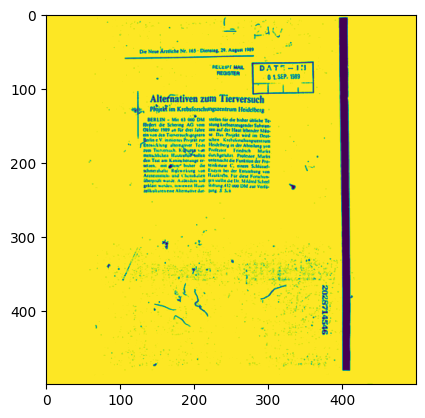

In [11]:
if is_notebook():
  plt.imshow(train_set[3][0])

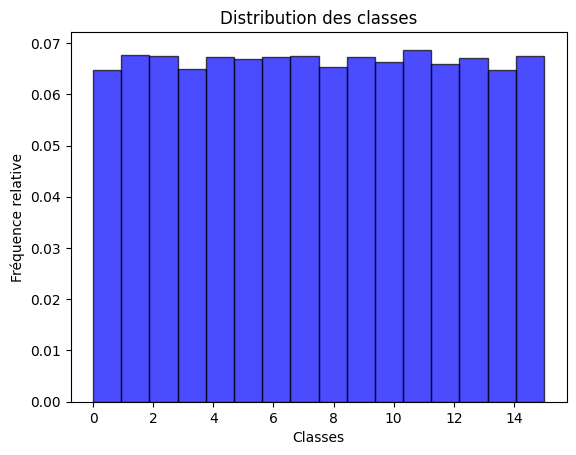

In [12]:
if is_notebook():
  plt.hist(dataset['validation']['label'], bins=NB_CLASSES, density=True, alpha=0.7, color='blue', edgecolor='black')

  plt.title('Distribution des classes')
  plt.xlabel('Classes')
  plt.ylabel('Fréquence relative')

## Model

In [13]:
class LitJQOVResNetClassifier(L.LightningModule):
    def __init__(self, dim_in:int, dim_out:int, lr:float, residual:bool=True, dim_in_last_layer = 512*32*32//4, optimizer=torch.optim.Adam):
        super().__init__()
        self.save_hyperparameters()

        cnn_conf = [[1, 64, 7], [6, 64, 3], [8, 128, 3], [12, 256, 3], [6, 512, 3]]

        layers = []

        for index, conf in enumerate(cnn_conf):
            nb_layer, nb_kernel, kernel_size = conf
            for i in range(nb_layer):
                seq = []
                seq.append(nn.Conv2d(dim_in, nb_kernel, kernel_size=kernel_size, stride=2 if i == 0 and index > 1 else 1, padding=(kernel_size-1)//2))
                seq.append(nn.BatchNorm2d(nb_kernel))
                seq.append(nn.ReLU())
                if index == 0:
                    seq.append(nn.MaxPool2d(kernel_size=2, stride=2))
                layers.append(nn.Sequential(*seq))
                dim_in = nb_kernel

        self.lr = lr
        self.cnn_layers = nn.ModuleList(layers)
        self.dim_in_last_layer = dim_in_last_layer
        self.max_pooling = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(dim_in_last_layer, dim_out, bias=True)
        self.optimizer_builder = optimizer
        self.residual = residual

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn_layers[0](x)

        if self.residual:
            res = x

        for i in range((len(self.cnn_layers)-1) // 2):
            if self.residual:
                x = x + res

            for j in range(2):
                x = self.cnn_layers[1+2*i+j](x)

            res = x

        x = x + res

        x = self.max_pooling(x)

        x = self.flatten(x)

        x = self.fc(x)

        return x

    def training_validation_test_step(self, batch, batch_idx, mode='train'):
        x, y = batch
        y_pred = self(x)

        loss = nn.functional.cross_entropy(input=y_pred, target=y)
        acc = my_accuracy(y=y_pred, y_true=y)

        self.log(mode + '_loss', loss.item(), on_epoch=True, prog_bar=True, sync_dist=True)
        self.log(mode + '_acc', acc.item(), on_epoch=True, prog_bar=True, sync_dist=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self.training_validation_test_step(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
        return self.training_validation_test_step(batch, batch_idx, 'val')

    def test_step(self, batch, batch_idx):
        return self.training_validation_test_step(batch, batch_idx, 'test')

    def configure_optimizers(self):
        return self.optimizer_builder(self.parameters(), lr=self.lr)

## Optimization

In [14]:
# Training function

from typing import List, Tuple, Any

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint


def train_func(lr:float, batch_sz:int, epochs:int, earlystop:int, \
               train_dataset, val_dataset, \
               Classifier, nb_classes, residual, \
               accelerator='cpu', devices='auto', best_model_filename='best_model'):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_sz, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_sz)

    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=earlystop,
        verbose=True,
        mode='min'
    )

    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        filename=best_model_filename,
        save_top_k=1,
        mode='min',
        enable_version_counter=False
    )
    
    trainer = Trainer(
        max_epochs=epochs,
        accelerator=accelerator,
        devices=devices,
        callbacks=[checkpoint_callback, early_stop_callback],
        enable_progress_bar=True,
        logger=False
    )
    
    model = Classifier(dim_in=1, dim_out=nb_classes, lr=lr, residual=residual)

    print(model)
    
    trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

    return model, trainer.validate(ckpt_path='best', dataloaders=val_dataloader)[0]['val_acc']

In [15]:
import pickle

residual_val_accs = []
non_residual_val_accs = []

for _ in range(5):
  model, acc = train_func(lr=LEARNING_RATE, batch_sz=BATCH_SIZE, epochs=EPOCHS, earlystop=EARLY_STOP, \
                train_dataset=train_set, val_dataset=val_set, \
                Classifier=LitJQOVResNetClassifier, nb_classes=NB_CLASSES, residual=True, \
                accelerator='cpu' if len(GPUS) == 0 else 'gpu', devices='auto' if len(GPUS) == 0 else GPUS, best_model_filename='residual_best_model')
  residual_val_accs.append(acc)

  save_results(residual_val_accs, non_residual_val_accs)

  if (acc >= max(non_residual_val_accs + [0])):
    with open ('./checkpoints/residual_best_model.pickle', 'wb') as fp:
      pickle.dump(model, fp)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LitJQOVResNetClassifier(
  (cnn_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1-6): 6 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (7): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (8-14): 7 x Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | cnn_layers  | ModuleList | 21.1 M
1 | max_pooling | MaxPool2d  | 0     
2 | flatten     | Flatten    | 0     
3 | fc          | Linear     | 2.1 M 
-------------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.837    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\GitHub\deep-learning-projet\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


d:\GitHub\deep-learning-projet\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 4/4 [03:36<00:00,  0.02it/s, train_loss_step=110.0, train_acc_step=0.000, val_loss=136.0, val_acc=0.110, train_loss_epoch=44.60, train_acc_epoch=0.060]

Metric val_loss improved. New best score: 136.448


Epoch 1: 100%|██████████| 4/4 [03:13<00:00,  0.02it/s, train_loss_step=101.0, train_acc_step=0.000, val_loss=17.60, val_acc=0.070, train_loss_epoch=42.10, train_acc_epoch=0.080] 

Metric val_loss improved by 118.853 >= min_delta = 0.0. New best score: 17.595


Epoch 4: 100%|██████████| 4/4 [03:03<00:00,  0.02it/s, train_loss_step=32.90, train_acc_step=0.000, val_loss=3.08e+3, val_acc=0.090, train_loss_epoch=26.30, train_acc_epoch=0.080] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 17.595. Signaling Trainer to stop.


Epoch 4: 100%|██████████| 4/4 [03:03<00:00,  0.02it/s, train_loss_step=32.90, train_acc_step=0.000, val_loss=3.08e+3, val_acc=0.090, train_loss_epoch=26.30, train_acc_epoch=0.080]


Restoring states from the checkpoint path at d:\GitHub\deep-learning-projet\checkpoints\residual_best_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at d:\GitHub\deep-learning-projet\checkpoints\residual_best_model.ckpt


Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.07000000029802322
        val_loss            17.594907760620117
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\GitHub\deep-learning-projet\.venv\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:639: Checkpoint directory d:\GitHub\deep-learning-projet\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | cnn_layers  | ModuleList | 21.1 M
1 | max_pooling | MaxPool2d  | 0     
2 | flatten     | Flatten    | 0     
3 | fc          | Linear     | 2.1 M 
-------------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.837    Total estimated model params size (MB)


LitJQOVResNetClassifier(
  (cnn_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1-6): 6 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (7): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (8-14): 7 x Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(

Metric val_loss improved. New best score: 198.407


Epoch 1: 100%|██████████| 4/4 [03:05<00:00,  0.02it/s, train_loss_step=34.40, train_acc_step=0.000, val_loss=176.0, val_acc=0.060, train_loss_epoch=32.10, train_acc_epoch=0.060] 

Metric val_loss improved by 22.325 >= min_delta = 0.0. New best score: 176.082


Epoch 2: 100%|██████████| 4/4 [03:04<00:00,  0.02it/s, train_loss_step=150.0, train_acc_step=0.000, val_loss=96.80, val_acc=0.110, train_loss_epoch=54.10, train_acc_epoch=0.080] 

Metric val_loss improved by 79.269 >= min_delta = 0.0. New best score: 96.814


Epoch 5: 100%|██████████| 4/4 [03:02<00:00,  0.02it/s, train_loss_step=265.0, train_acc_step=0.000, val_loss=2.85e+6, val_acc=0.100, train_loss_epoch=115.0, train_acc_epoch=0.060] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 96.814. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 4/4 [03:02<00:00,  0.02it/s, train_loss_step=265.0, train_acc_step=0.000, val_loss=2.85e+6, val_acc=0.100, train_loss_epoch=115.0, train_acc_epoch=0.060]


Restoring states from the checkpoint path at d:\GitHub\deep-learning-projet\checkpoints\residual_best_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at d:\GitHub\deep-learning-projet\checkpoints\residual_best_model.ckpt


Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.10999999940395355
        val_loss             96.8136215209961
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | cnn_layers  | ModuleList | 21.1 M
1 | max_pooling | MaxPool2d  | 0     
2 | flatten     | Flatten    | 0     
3 | fc          | Linear     | 2.1 M 
-------------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.837    Total estimated model params size (MB)


LitJQOVResNetClassifier(
  (cnn_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1-6): 6 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (7): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (8-14): 7 x Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(

Metric val_loss improved. New best score: 995.642


Epoch 1: 100%|██████████| 4/4 [03:14<00:00,  0.02it/s, train_loss_step=144.0, train_acc_step=0.000, val_loss=103.0, val_acc=0.080, train_loss_epoch=35.90, train_acc_epoch=0.030] 

Metric val_loss improved by 892.963 >= min_delta = 0.0. New best score: 102.679


Epoch 4: 100%|██████████| 4/4 [03:10<00:00,  0.02it/s, train_loss_step=83.80, train_acc_step=0.250, val_loss=1.61e+6, val_acc=0.080, train_loss_epoch=33.90, train_acc_epoch=0.100] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 102.679. Signaling Trainer to stop.


Epoch 4: 100%|██████████| 4/4 [03:10<00:00,  0.02it/s, train_loss_step=83.80, train_acc_step=0.250, val_loss=1.61e+6, val_acc=0.080, train_loss_epoch=33.90, train_acc_epoch=0.100]


Restoring states from the checkpoint path at d:\GitHub\deep-learning-projet\checkpoints\residual_best_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at d:\GitHub\deep-learning-projet\checkpoints\residual_best_model.ckpt


Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.07999999821186066
        val_loss            102.67904663085938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | cnn_layers  | ModuleList | 21.1 M
1 | max_pooling | MaxPool2d  | 0     
2 | flatten     | Flatten    | 0     
3 | fc          | Linear     | 2.1 M 
-------------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.837    Total estimated model params size (MB)


LitJQOVResNetClassifier(
  (cnn_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1-6): 6 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (7): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (8-14): 7 x Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(

Metric val_loss improved. New best score: 835.706


Epoch 1: 100%|██████████| 4/4 [03:17<00:00,  0.02it/s, train_loss_step=39.20, train_acc_step=0.000, val_loss=468.0, val_acc=0.110, train_loss_epoch=46.30, train_acc_epoch=0.070] 

Metric val_loss improved by 367.389 >= min_delta = 0.0. New best score: 468.317


Epoch 2: 100%|██████████| 4/4 [03:10<00:00,  0.02it/s, train_loss_step=106.0, train_acc_step=0.000, val_loss=91.00, val_acc=0.080, train_loss_epoch=62.20, train_acc_epoch=0.100] 

Metric val_loss improved by 377.356 >= min_delta = 0.0. New best score: 90.961


Epoch 4:  25%|██▌       | 1/4 [00:18<00:54,  0.05it/s, train_loss_step=137.0, train_acc_step=0.000, val_loss=2.04e+4, val_acc=0.040, train_loss_epoch=68.70, train_acc_epoch=0.060]

d:\GitHub\deep-learning-projet\.venv\lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
Restoring states from the checkpoint path at d:\GitHub\deep-learning-projet\checkpoints\residual_best_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at d:\GitHub\deep-learning-projet\checkpoints\residual_best_model.ckpt


Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]

TypeError: 'NoneType' object is not subscriptable

In [15]:
import pickle

for _ in range(5):
  model, acc = train_func(lr=LEARNING_RATE, batch_sz=BATCH_SIZE, epochs=EPOCHS, earlystop=EARLY_STOP, \
                train_dataset=train_set, val_dataset=val_set, \
                Classifier=LitJQOVResNetClassifier, nb_classes=NB_CLASSES, residual=False, \
                accelerator='cpu' if len(GPUS) == 0 else 'gpu', devices='auto' if len(GPUS) == 0 else GPUS, best_model_filename='not_residual_best_model')
  non_residual_val_accs.append(acc)

  save_results(residual_val_accs, non_residual_val_accs)

  if (acc >= max(non_residual_val_accs + [0])):
    with open ('./checkpoints/not_residual_best_model.pickle', 'wb') as fp:
      pickle.dump(model, fp)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
d:\GitHub\deep-learning-projet\.venv\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:639: Checkpoint directory d:\GitHub\deep-learning-projet\checkpoints exists and is not empty.


LitJQOVResNetClassifier(
  (cnn_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1-6): 6 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (7): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (8-14): 7 x Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | cnn_layers  | ModuleList | 21.1 M
1 | max_pooling | MaxPool2d  | 0     
2 | flatten     | Flatten    | 0     
3 | fc          | Linear     | 2.1 M 
-------------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.837    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\GitHub\deep-learning-projet\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


d:\GitHub\deep-learning-projet\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 4/4 [03:50<00:00,  0.02it/s, train_loss_step=12.00, train_acc_step=0.500, val_loss=83.80, val_acc=0.080, train_loss_epoch=38.00, train_acc_epoch=0.090]

Metric val_loss improved. New best score: 83.788


Epoch 3: 100%|██████████| 4/4 [02:43<00:00,  0.02it/s, train_loss_step=18.40, train_acc_step=0.000, val_loss=24.90, val_acc=0.110, train_loss_epoch=31.80, train_acc_epoch=0.110] 

Metric val_loss improved by 58.878 >= min_delta = 0.0. New best score: 24.911


Epoch 6: 100%|██████████| 4/4 [02:42<00:00,  0.02it/s, train_loss_step=150.0, train_acc_step=0.000, val_loss=973.0, val_acc=0.060, train_loss_epoch=14.10, train_acc_epoch=0.150]  

Monitored metric val_loss did not improve in the last 3 records. Best score: 24.911. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 4/4 [02:42<00:00,  0.02it/s, train_loss_step=150.0, train_acc_step=0.000, val_loss=973.0, val_acc=0.060, train_loss_epoch=14.10, train_acc_epoch=0.150]


Restoring states from the checkpoint path at d:\GitHub\deep-learning-projet\checkpoints\not_residual_best_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at d:\GitHub\deep-learning-projet\checkpoints\not_residual_best_model.ckpt


Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.10999999940395355
        val_loss            24.910642623901367
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


NameError: name 'non_residual_val_accs' is not defined